In [1]:
#import all necessary modules
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,image 
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.models import Sequential,Model,load_model
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#define height and width of the image
height=300
width=300

#create a ResNet50 model instance without the top layer as we will add our own top layer
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

In [3]:
#define directory containing training and validation data
train_dir=r"C:\Users\Chandu\Desktop\rice\data\train"
validation_dir=r"C:\Users\Chandu\Desktop\rice\data\valid"

#number of batches the data has to be divided into
batch_size=8

#create datagen and generator to load the data from training directory
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(height,width),batch_size=batch_size)

#create datagen and generator to load the data from validation directory
validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(height,width),batch_size=batch_size)

Found 749 images belonging to 5 classes.
Found 220 images belonging to 5 classes.


In [4]:
#our own model which will be added onto the ResNet50 model
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
    for layer in base_model.layers:
        layer.trainable=False

    x=base_model.output
    x=Flatten()(x)
    for fc in fc_layers:
        x=Dense(fc,activation='relu')(x)
        x=Dropout(dropout)(x)
    
    predictions=Dense(num_classes,activation='softmax')(x)

    finetune_model=Model(inputs=base_model.input,outputs=predictions) 
    
    return finetune_model

class_list=['broken','chalky','full','mixed','unpolished'] #the labels of our data
FC_Layers=[1024,1024]
dropout=0.5

finetune_model=build_finetune_model(base_model,dropout=dropout,fc_layers=FC_Layers,num_classes=len(class_list))

In [5]:
#define number of epochs(the number of times the model will be trained) and number of training images
num_epochs=100
num_train_images=749


In [6]:
#checkpoint in case anything goes wrong
checkpoint=ModelCheckpoint("Final_model.h5",monitor='val_acc',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early=EarlyStopping(monitor='val_acc',min_delta=0,patience=40,verbose=1,mode="auto")

#compile the model before using
finetune_model.compile(loss="categorical_crossentropy",optimizer=optimizers.SGD(lr=0.000001,momentum=0.9),metrics=['accuracy'])

#train the model
finetune_model.fit_generator(generator=train_generator,steps_per_epoch=num_train_images//batch_size,epochs=num_epochs,validation_data=validation_generator,validation_steps=1,callbacks=[checkpoint,early])

#save the model
finetune_model.save_weights("Final_model.h5")

C:\Users\Chandu\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\Users\Chandu\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
93/93 [==============================] - 189s 2s/step - loss: 2.7450 - accuracy: 0.3414 - val_loss: 0.6379 - val_accuracy: 0.8750
Epoch 2/100
93/93 [==============================] - 194s 2s/step - loss: 1.5681 - accuracy: 0.5520 - val_loss: 1.4521 - val_accuracy: 0.6250
Epoch 3/100
93/93 [==============================] - 181s 2s/step - loss: 1.4895 - accuracy: 0.5911 - val_loss: 0.9380 - val_accuracy: 0.6250
Epoch 4/100
93/93 [==============================] - 181s 2s/step - loss: 1.1932 - accuracy: 0.6491 - val_loss: 1.2476 - val_accuracy: 0.6250
Epoch 5/100
93/93 [==============================] - 182s 2s/step - loss: 1.0836 - accuracy: 0.6802 - val_loss: 0.3741 - val_accuracy: 0.8750
Epoch 6/100
93/93 [==============================] - 182s 2s/step - loss: 1.0943 - accuracy: 0.6802 - val_loss: 0.8139 - val_accuracy: 0.8750
Epoch 7/100
93/93 [==============================] - 188s 2s/step - loss: 0.8666 - accuracy: 0.7314 - val_loss: 0.8911 - val_accuracy: 0.6250
Epoch 

broken 0.99313825
chalky 0.00039157912
full 0.00033751226
mixed 0.00027690735
unpolished 0.005855778


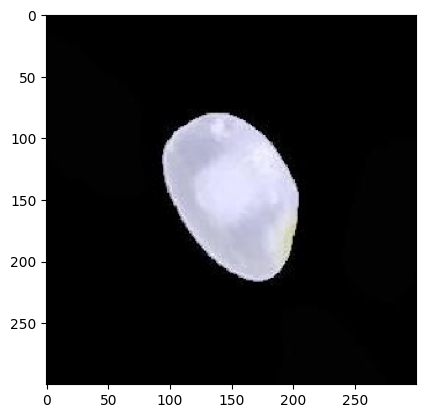

In [7]:
#testing the model
img=image.load_img(r"C:\Users\Chandu\Desktop\rice\data\train\broken\(3).jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
print("broken",output[0][0]) #comparison
print("chalky",output[0][1])
print("full",output[0][2])
print("mixed",output[0][3])
print("unpolished",output[0][4])

broken 0.0077510346
chalky 0.00047604213
full 0.0011298439
mixed 0.00793441
unpolished 0.9827087


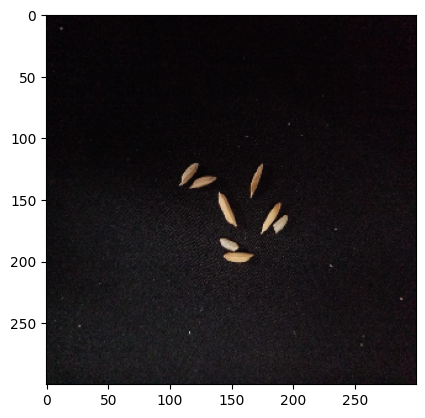

In [8]:
#testing the model
img=image.load_img(r"C:\Users\Chandu\Desktop\rice\data\train\unpolished\(2).jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
print("broken",output[0][0]) #comparison
print("chalky",output[0][1])
print("full",output[0][2])
print("mixed",output[0][3])
print("unpolished",output[0][4])

broken 0.0025214537
chalky 0.9947524
full 0.000885008
mixed 0.00047909716
unpolished 0.0013620213


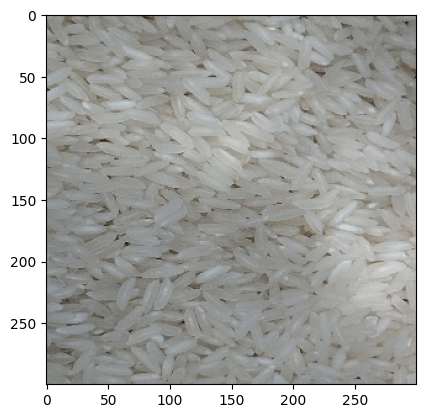

In [9]:
#testing the model
img=image.load_img(r"C:\Users\Chandu\Desktop\rice\data\train\chalky\(6).jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
print("broken",output[0][0]) #comparison
print("chalky",output[0][1])
print("full",output[0][2])
print("mixed",output[0][3])
print("unpolished",output[0][4])

broken 0.0020005293
chalky 0.13821545
full 0.0035070963
mixed 0.84701735
unpolished 0.009259609


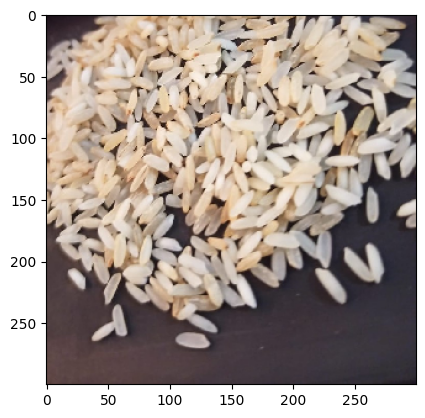

In [10]:
#testing the model
img=image.load_img(r"C:\Users\Chandu\Desktop\rice\data\train\mixed\(6).jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
print("broken",output[0][0]) #comparison
print("chalky",output[0][1])
print("full",output[0][2])
print("mixed",output[0][3])
print("unpolished",output[0][4])

broken 0.00037163467
chalky 0.0019511263
full 0.81636065
mixed 0.0050423397
unpolished 0.1762742


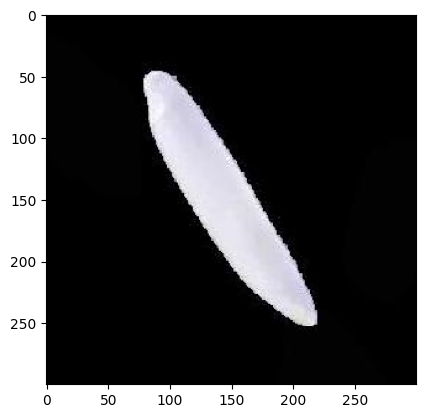

In [62]:
#testing the model
img=image.load_img(r"C:\Users\Chandu\Desktop\rice\data\train\full rice\(54).jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
print("broken",output[0][0]) #comparison
print("chalky",output[0][1])
print("full",output[0][2])
print("mixed",output[0][3])
print("unpolished",output[0][4])